In [1]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
from tqdm import trange
import random
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score
from utils import load_anno_data
from bertopic import BERTopic
from TopicTuner.topictuner import TopicModelTuner as TMT
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sklearn.model_selection import StratifiedKFold
from hdbscan import HDBSCAN
# torch.cuda.empty_cache()


In [24]:



# df = load_anno_data()
df = pd.read_csv('../data/annotated_target_topic_data.csv')
hate_df = df[df['label']=='hatespeech'].reset_index()
# docs = [' '.join(x) for x in df.tokens.values]
# hate_df = hate_df[hate_df['target'].isin({'Asian', 'Other', 'None', 'Women', 'Hispanic'})]
hate_df[hate_df['target']=='Arab']['target'] = 'Islam'
labels_counter = Counter(hate_df.target.tolist())
# hate_df[~hate_df['target'].isin(x[0] for x in labels_counter.most_common(4))] = 'other'
hate_df = hate_df[hate_df['target'].isin(x[0] for x in labels_counter.most_common(4))]


In [3]:
import sklearn
le = sklearn.preprocessing.LabelEncoder()
text = hate_df.text.values
labels = le.fit_transform(hate_df.target.values)
unique_labels= list(set(labels))
num_labels= len(unique_labels)

In [4]:
topic_model = BERTopic.load('model')
topics, probs = topic_model.fit_transform(text)
hate_df['topic'] = topics

Mon Jan 16 21:01:29 2023 Building and compiling search function
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=5, n_neighbors=5, verbose=2)
Mon Jan 16 21:01:38 2023 Construct fuzzy simplicial set
Mon Jan 16 21:01:38 2023 Finding Nearest Neighbors
Mon Jan 16 21:01:38 2023 Building RP forest with 8 trees
Mon Jan 16 21:01:38 2023 NN descent for 12 iterations
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	Stopping threshold met -- exiting after 8 iterations
Mon Jan 16 21:02:15 2023 Finished Nearest Neighbor Search
Mon Jan 16 21:02:18 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jan 16 21:02:24 2023 Finished embedding


In [22]:
topic_model.topic_names

{0: '0_nigger_niggers_white_number',
 1: '1_kike_jews_jew_white',
 2: '2_moslem_muslim_number_islam',
 3: '3_faggot_faggots_like_user'}

In [5]:
Counter(labels.tolist())

Counter({3: 1131, 0: 2125, 2: 1018, 1: 538})

In [6]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True,
    truncation=True
    )

In [35]:
def preprocessing(input_text,  tokenizer, topic_name=None):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''

  tokens_text = tokenizer.tokenize(input_text)
  if topic_name:
    tokens_topic = tokenizer.tokenize(topic_name)
    addition = ['[SEP]'] + tokens_topic
  else:
    addition = []
  tokens = tokens_text+addition
  return tokenizer.encode_plus(
                        tokens,
                        add_special_tokens = True,
                        max_length = MAX_LEN,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


def get_topic_name_by_doc_ind(i):
    topic = hate_df.reset_index().iloc[i]['topics']
    topic_name = topic_model.topic_names[topic]
    return topic_name

def data_loader(token_id, attention_masks, labels, train_idx, val_idx, batch_size):
    # Train and validation sets
    train_set = TensorDataset(token_id[train_idx], 
                              attention_masks[train_idx], 
                              labels[train_idx])

    val_set = TensorDataset(token_id[val_idx], 
                            attention_masks[val_idx], 
                            labels[val_idx])

    # Prepare DataLoader
    train_dataloader = DataLoader(
                train_set,
                sampler = RandomSampler(train_set),
                batch_size = batch_size
            )

    validation_dataloader = DataLoader(
                val_set,
                sampler = SequentialSampler(val_set),
                batch_size = batch_size
            )
    return train_dataloader, validation_dataloader

def create_model(num_labels):
    # Load the BertForSequenceClassification model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels = num_labels,
        output_attentions = False,
        output_hidden_states = False,
    )

    # Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
    optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr = 5e-5,
                                  eps = 1e-08
                                  )
    return model, optimizer


In [39]:
token_id = []
attention_masks = []
with_topic=True
MAX_LEN = max([len(x.split()) for x in text])
print(MAX_LEN)
for i, sample in enumerate(text):
  topic_name = None
  if with_topic:
    topic_id = topics[i]
    topic_name = topic_model.topic_names[topic_id]
    topic_name = ' '.join(topic_name.split('_')[1:])
  encoding_dict = preprocessing(sample,tokenizer , topic_name)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

165


In [40]:
n=5
seed = 42
kf = StratifiedKFold(n_splits=n, random_state=seed, shuffle=True)
is_kf = False
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)
if is_kf:
    split_range = kf.split(text, labels)
else:
    split_range = [(train_idx, val_idx)]


In [41]:
import gc
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Run on GPU
# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
results = []
for train_idx, val_idx in split_range:
    torch.cuda.empty_cache()
    gc.collect()
    model, optimizer = create_model(num_labels)
    model = model.to(device)
    train_dataloader, validation_dataloader = data_loader(token_id, attention_masks, labels, train_idx, val_idx, batch_size)
    accuracy_scores = {'train':[], 'val':[]}
    losses_scores = {'train':[], 'val':[]}
    for epoch in trange(epochs, desc = 'Epoch'):

        # ========== Training ==========

        # Set model to training mode
        model.train()

        # Tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        # Tracking variables 
        true_labels = []
        pred_labels = []
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # b_labels = b_labels.type(torch.LongTensor)
            optimizer.zero_grad()
            # Forward pass
            train_output = model(b_input_ids, 
                                 token_type_ids = None, 
                                 attention_mask = b_input_mask, 
                                 labels = b_labels)
            # Backward pass
            train_output.loss.backward()
            optimizer.step()
            # Update tracking variables
            
            
            
#             class_weights=class_weight.compute_class_weight('balanced',np.unique(y),y.numpy())
#             class_weights=torch.tensor(class_weights,dtype=torch.float)

#             print(class_weights) #([1.0000, 1.0000, 4.0000, 1.0000, 0.5714])
#             logits = outputs['logits']
#             criterion = torch.nn.CrossEntropyLoss(weights=class_weights)
#             loss = criterion(logits, inputs['labels'])
            
            
            
            tr_loss += train_output.loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
            preds = torch.argmax(train_output.logits, dim=1)
            true_labels.extend(b_labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
        # Calculate the evaluation metrics
        tr_accuracy = accuracy_score(true_labels, pred_labels)
        precision = recall_score(true_labels, pred_labels, average='macro')
        recall = precision_score(true_labels, pred_labels, average='macro')
        f1 = f1_score(true_labels, pred_labels, average='macro')
        losses_scores['train'].append(tr_loss/nb_tr_steps)
        accuracy_scores['train'].append(tr_accuracy)
        train_text_to_print = f'Epoch {epoch+1}:\nTrain evaluation\nloss = {tr_loss/nb_tr_steps:.3f} accuracy = {tr_accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}\n'

        # Set model to evaluation mode
        model.eval()

        # Tracking variables 
        true_labels = []
        pred_labels = []
        ts_loss = 0
        nb_ts_steps = 0
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # b_labels = b_labels.type(torch.LongTensor)
            # with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids, 
                                token_type_ids = None, 
                                attention_mask = b_input_mask,
                                labels = b_labels)
            # logits = eval_output.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Convert the logits to predictions
            preds = torch.argmax(eval_output.logits, dim=1)
            true_labels.extend(b_labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            ts_loss += eval_output.loss.item()
            nb_ts_steps += 1
        # Calculate the evaluation metrics
        ts_accuracy = accuracy_score(true_labels, pred_labels)
        precision = recall_score(true_labels, pred_labels, average='macro')
        recall = precision_score(true_labels, pred_labels, average='macro')
        f1 = f1_score(true_labels, pred_labels, average='macro')
        losses_scores['val'].append(ts_loss/nb_ts_steps)
        accuracy_scores['val'].append(ts_accuracy)
        # Print the evaluation metrics
        val_text_to_print = f'Validation evaluation\nloss = {ts_loss/nb_ts_steps:.3f} accuracy = {ts_accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}\n'
        print(train_text_to_print+val_text_to_print)
    del model
    del train_output
    del eval_output
    results.append((tr_accuracy, ts_accuracy))

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1:
Train evaluation
loss = 0.446 accuracy = 0.866, precision = 0.840, recall = 0.852, f1 = 0.845
Validation evaluation
loss = 0.308 accuracy = 0.912, precision = 0.876, recall = 0.901, f1 = 0.887



Epoch:  20%|██        | 2/10 [01:27<05:49, 43.73s/it]

Epoch 2:
Train evaluation
loss = 0.216 accuracy = 0.930, precision = 0.914, recall = 0.920, f1 = 0.917
Validation evaluation
loss = 0.275 accuracy = 0.911, precision = 0.880, recall = 0.906, f1 = 0.892



Epoch:  30%|███       | 3/10 [02:11<05:08, 44.09s/it]

Epoch 3:
Train evaluation
loss = 0.138 accuracy = 0.956, precision = 0.945, recall = 0.951, f1 = 0.948
Validation evaluation
loss = 0.258 accuracy = 0.921, precision = 0.886, recall = 0.920, f1 = 0.900



Epoch:  40%|████      | 4/10 [02:56<04:25, 44.33s/it]

Epoch 4:
Train evaluation
loss = 0.100 accuracy = 0.969, precision = 0.960, recall = 0.966, f1 = 0.963
Validation evaluation
loss = 0.323 accuracy = 0.919, precision = 0.902, recall = 0.902, f1 = 0.901



Epoch:  50%|█████     | 5/10 [03:41<03:42, 44.48s/it]

Epoch 5:
Train evaluation
loss = 0.079 accuracy = 0.978, precision = 0.972, recall = 0.976, f1 = 0.974
Validation evaluation
loss = 0.291 accuracy = 0.926, precision = 0.914, recall = 0.908, f1 = 0.911



Epoch:  60%|██████    | 6/10 [04:26<02:58, 44.59s/it]

Epoch 6:
Train evaluation
loss = 0.038 accuracy = 0.992, precision = 0.990, recall = 0.992, f1 = 0.991
Validation evaluation
loss = 0.350 accuracy = 0.921, precision = 0.905, recall = 0.906, f1 = 0.905



Epoch:  70%|███████   | 7/10 [05:10<02:13, 44.66s/it]

Epoch 7:
Train evaluation
loss = 0.041 accuracy = 0.990, precision = 0.985, recall = 0.989, f1 = 0.987
Validation evaluation
loss = 0.314 accuracy = 0.925, precision = 0.910, recall = 0.905, f1 = 0.907



Epoch:  80%|████████  | 8/10 [05:55<01:29, 44.74s/it]

Epoch 8:
Train evaluation
loss = 0.048 accuracy = 0.987, precision = 0.985, recall = 0.986, f1 = 0.986
Validation evaluation
loss = 0.364 accuracy = 0.921, precision = 0.900, recall = 0.911, f1 = 0.904



Epoch:  90%|█████████ | 9/10 [06:40<00:44, 44.81s/it]

Epoch 9:
Train evaluation
loss = 0.033 accuracy = 0.991, precision = 0.989, recall = 0.990, f1 = 0.989
Validation evaluation
loss = 0.495 accuracy = 0.904, precision = 0.882, recall = 0.885, f1 = 0.882



Epoch: 100%|██████████| 10/10 [07:25<00:00, 44.58s/it]

Epoch 10:
Train evaluation
loss = 0.037 accuracy = 0.989, precision = 0.987, recall = 0.989, f1 = 0.988
Validation evaluation
loss = 0.491 accuracy = 0.900, precision = 0.889, recall = 0.880, f1 = 0.884



In [11]:
pd.DataFrame(results, columns=['tr_acc', 'val_acc']).mean(axis=0)

tr_acc     0.980414
val_acc    0.936617
dtype: float64

In [42]:
new_sentence = 'all they think about it is rap, guns and drugs'
topic_id = topic_model.transform([new_sentence])[0][0]
topic_name = topic_model.topic_names[topic_id]
encoding_dict = preprocessing(new_sentence, topic_name, tokenizer)
# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []


# Extract IDs and Attention Mask
test_ids.append(encoding_dict['input_ids'])
test_attention_mask.append(encoding_dict['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = le.inverse_transform([output.logits.cpu().data.numpy().argmax()])


print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)
print("Topic name: ", topic_name)

Mon Jan 16 22:10:55 2023 Worst tree score: 0.20157938
Mon Jan 16 22:10:55 2023 Mean tree score: 0.20856712
Mon Jan 16 22:10:55 2023 Best tree score: 0.21799667
Mon Jan 16 22:10:58 2023 Forward diversification reduced edges from 24060 to 15419
Mon Jan 16 22:11:01 2023 Reverse diversification reduced edges from 15419 to 15419
Mon Jan 16 22:11:04 2023 Degree pruning reduced edges from 16924 to 16263
Mon Jan 16 22:11:04 2023 Resorting data and graph based on tree order
Mon Jan 16 22:11:04 2023 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

AttributeError: 'str' object has no attribute 'tokenize'

<AxesSubplot:title={'center':'Loss'}>

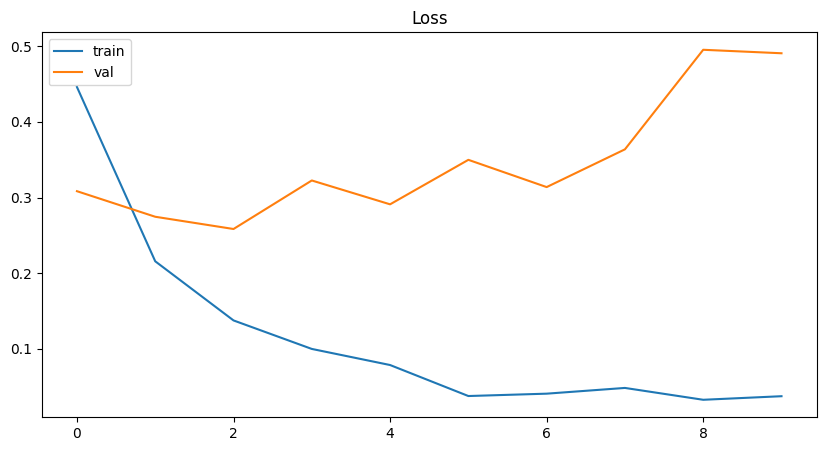

In [43]:
pd.DataFrame(losses_scores).plot(title='Loss',figsize=(10,5))

<AxesSubplot:title={'center':'Accuracy'}>

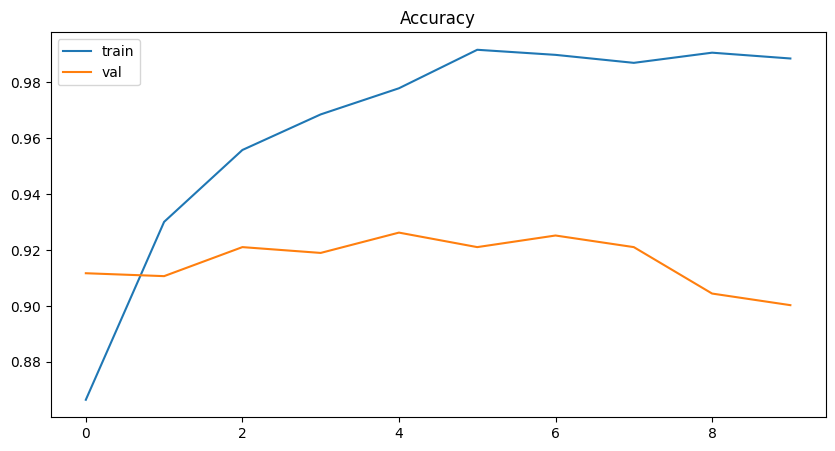

In [44]:
pd.DataFrame(accuracy_scores).plot(title='Accuracy',figsize=(10,5))

In [23]:
hate_df

,index,Unnamed: 0,label,target,tokens,text,topics,topic
2,5,13851720_gab,hatespeech,Jewish,"['laura', 'loomer', 'raped', 'me', 'while', 's...",laura loomer raped me while screaming at me in...,-1_the_to_and_is,2
3,6,24198545_gab,hatespeech,African,"['and', 'this', 'is', 'why', 'i', 'end', 'up',...",and this is why i end up with nigger trainee d...,1_nigger_niggers_the_you,0
4,8,19679648_gab,hatespeech,African,"['guilty', 'until', 'proven', 'innocent', 'unl...",guilty until proven innocent unless you are a ...,3_white_user_the_and,1
5,9,15858421_gab,hatespeech,African,"['tired', 'i', 'can', 'not', 'support', 'abort...",tired i can not support abortion from a moral ...,9_raped_user_women_and,0
6,10,23844035_gab,hatespeech,Islam,"['<number>', '<number>', '<percent>', 'of', 'b...",<number> <number> <percent> of brits think mul...,0_muslim_the_to_and,2
...,...,...,...,...,...,...,...,...
6227,20122,9844694_gab,hatespeech,Jewish,"['this', 'is', 'pretty', 'much', 'the', 'concl...",this is pretty much the conclusion of the fran...,2_jews_the_arabs_of,1
6228,20123,9845733_gab,hatespeech,Jewish,"['do', 'not', 'for', 'get', 'my', 'followers',...",do not for get my followers the jews have decl...,2_jews_the_arabs_of,1
6229,20128,9867117_gab,hatespeech,Islam,"['well', 'my', 'dear', 'lgbtq', 'brothers', 'a...",well my dear lgbtq brothers and sisters i do n...,0_muslim_the_to_and,2
6230,20134,9875482_gab,hatespeech,African,"['c', 'mon', 'men', 'charge', 'it', 'for', 'th...",c mon men charge it for the gays trannies musl...,0_muslim_the_to_and,3
